# Stock Market Prediction Model of the Magnificient Seven 

### pip install the dependencies from requirements. May take up to 12 minutes

In [1]:
!python3 -m pip install -r requirements.txt

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/Library/Developer/CommandLineTools/usr/bin/python3 -m pip install --upgrade pip' command.


### importing our libraries after pipinstall

In [2]:

#python data manipulation
import pandas as pd
import numpy as np

#data visualizaiton tools, EDA
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math


#LSTM Neural network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf

# our finance data
import yfinance as yf

#ML 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

/Users/amara/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Extracting the Historical Data.


 ### The historical aspect of the data is starting from January 1st 2020 to yesterday (april 6th), We can adjust this to most recent always. We extracted the 7 companies and start with first 7 features from our project proposal: Date/time, open price, low price, high price, adjusted close price, trading volume

In [3]:
def extract_data(tickers, start_date="2020-01-01", end_date="2025-04-21", interval="1d"):
    # importing the yfinance api data, making sure the autoadjust is off because it overrides the close value if its on
    df = yf.download(tickers, start=start_date, end=end_date, interval=interval, auto_adjust=False)
    # tidying the data to make it better for analysis and transformation later
    df.columns = df.columns.swaplevel(0, 1)
    df = df.sort_index(axis=1, level=0)
    df_flat = df.stack(level=0, future_stack=True).reset_index()  
    df_flat.rename(columns={'level_0': 'Date'}, inplace=True)
    # renaming 'Adj Close' to 'Adj_Close' for consistency
    if 'Adj Close' in df_flat.columns:
        df_flat.rename(columns={'Adj Close': 'Adj_Close'}, inplace=True)
    # adding the previous day's close price per ticker
    df_flat['Previous_Close'] = df_flat.groupby('Ticker')['Close'].shift(1)
    # selecting the columns we expect and need
    expected_cols = ['Date', 'Ticker', 'Open', 'High', 'Low', 'Close', 'Adj_Close', 'Previous_Close', 'Volume']
    existing_cols = [col for col in expected_cols if col in df_flat.columns]
    return df_flat[existing_cols]

In [4]:
#giving yfinance a list of companies to return a list of data of. AND displaying the df
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]
df_raw = extract_data(tickers)
display(df_raw)

[*********************100%***********************]  7 of 7 completed


Price       Date Ticker        Open        High         Low       Close  \
0     2020-01-02   AAPL   74.059998   75.150002   73.797501   75.087502   
1     2020-01-02   AMZN   93.750000   94.900497   93.207497   94.900497   
2     2020-01-02  GOOGL   67.420502   68.433998   67.324501   68.433998   
3     2020-01-02   META  206.750000  209.789993  206.270004  209.779999   
4     2020-01-02   MSFT  158.779999  160.729996  158.330002  160.619995   
...          ...    ...         ...         ...         ...         ...   
9312  2025-04-17  GOOGL  154.289993  154.679993  148.500000  151.160004   
9313  2025-04-17   META  505.250000  507.299988  498.010010  501.480011   
9314  2025-04-17   MSFT  373.750000  374.320007  366.890015  367.779999   
9315  2025-04-17   NVDA  104.449997  104.470001  100.050003  101.489998   
9316  2025-04-17   TSLA  243.470001  244.339996  237.679993  241.369995   

Price   Adj_Close  Previous_Close     Volume  
0       72.716064             NaN  135480400  
1       94.900497             NaN   80580000  
2       68.108376             NaN   27278000  
3      208.795929             NaN   12077100  
4      153.323318             NaN   22622100  
...           ...             ...        ...  
9312   151.160004      153.330002   32938500  
9313   501.480011      502.309998   14593500  
9314   367.779999      371.609985   20943700  
9315   101.489998      104.489998  290833400  
9316   241.369995      241.550003   83404800  

[9317 rows x 9 columns]

## Historical Data: Data Cleaning: 
### We will clean the data by taking care of any null values. We can use back and forward filling if there is a value missing from a float/int value. Otherwise we will drop the value if its in the date or Ticker/ or use the average of the past few days for the column. Additionally if there are are any duplicate records for a company and a speciifc date, one should be kept while rest dropped.

In [5]:
nans = df_raw.isna().sum()
print('Nans found in set:')
print(nans)
def cleaning(df):
    # dropping duplicates (keep the first entry for each Ticker-Date pair)
    df = df.drop_duplicates(subset=['Date', 'Ticker'], keep='first')

    # defining numeric columns to clean (excluding 'Date' and 'Ticker')
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Volume', 'Previous_Close']
    
    # filling missing values for numeric columns
    for col in numeric_cols:
        # forward fill and backward fill first
        df[col] = df.groupby('Ticker')[col].transform(lambda x: x.ffill().bfill())
        
        # fill remaining NaNs with rolling mean (3-day window)
        df[col] = df.groupby('Ticker')[col].transform(
            lambda x: x.fillna(x.rolling(window=3, min_periods=1).mean())
        )

    # checking that 'Previous_Close' is properly filled (first entry has no previous data)
    df['Previous_Close'] = df.groupby('Ticker')['Previous_Close'].ffill()

    # dropping rows with nulls in 'Date' or 'Ticker' (shouldn't exist, but safety check)
    df = df.dropna(subset=['Date', 'Ticker'])

    return df
# apply cleaning
df_cleaned = cleaning(df_raw)

# verify results
print("\n")
print("Null values after cleaning:")
print(df_cleaned.isna().sum())
print("\n Cleaned Dataset:")
display(df_cleaned)

Nans found in set:
Price
Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj_Close         0
Previous_Close    7
Volume            0
dtype: int64


Null values after cleaning:
Price
Date              0
Ticker            0
Open              0
High              0
Low               0
Close             0
Adj_Close         0
Previous_Close    0
Volume            0
dtype: int64

 Cleaned Dataset:


Price       Date Ticker        Open        High         Low       Close  \
0     2020-01-02   AAPL   74.059998   75.150002   73.797501   75.087502   
1     2020-01-02   AMZN   93.750000   94.900497   93.207497   94.900497   
2     2020-01-02  GOOGL   67.420502   68.433998   67.324501   68.433998   
3     2020-01-02   META  206.750000  209.789993  206.270004  209.779999   
4     2020-01-02   MSFT  158.779999  160.729996  158.330002  160.619995   
...          ...    ...         ...         ...         ...         ...   
9312  2025-04-17  GOOGL  154.289993  154.679993  148.500000  151.160004   
9313  2025-04-17   META  505.250000  507.299988  498.010010  501.480011   
9314  2025-04-17   MSFT  373.750000  374.320007  366.890015  367.779999   
9315  2025-04-17   NVDA  104.449997  104.470001  100.050003  101.489998   
9316  2025-04-17   TSLA  243.470001  244.339996  237.679993  241.369995   

Price   Adj_Close  Previous_Close     Volume  
0       72.716064       75.087502  135480400  
1       94.900497       94.900497   80580000  
2       68.108376       68.433998   27278000  
3      208.795929      209.779999   12077100  
4      153.323318      160.619995   22622100  
...           ...             ...        ...  
9312   151.160004      153.330002   32938500  
9313   501.480011      502.309998   14593500  
9314   367.779999      371.609985   20943700  
9315   101.489998      104.489998  290833400  
9316   241.369995      241.550003   83404800  

[9317 rows x 9 columns]

## Historical Data, Feature Engineering:

### We are going to be transforming the tidy dataframe by doing some feature engineering. We will create the following fields into our table by manipulating the prexisting data from df_cleaned: 
1. Simple Moving Average (SMA)
2. Exponential Moving Average (EMA)
3. Relative Strength Index (RSI)
4. Bollinger Bands
5. MACD (Moving Average Convergence Divergence)
6. On-Balance Volume (OBV)
7. Volatility (ATR - Average True Range)


In [6]:
def transform(df):
    # ensuring data is sorted by Ticker and Date
    df = df.sort_values(['Ticker', 'Date']).reset_index(drop=True)
    
    # 1. Simple Moving Average (SMA)
    #uses 20 periods of data (NaN till 19 row)
    df['SMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).mean())
    
    # 2. Exponential Moving Average (EMA)
    df['EMA_20'] = df.groupby('Ticker')['Close'].transform(lambda x: x.ewm(span=20, adjust=False).mean())
    
    # 3. Relative Strength Index (RSI)
    #uses 14 periods of data (NaN till 13 row)
    def compute_rsi(data, period=14):
        delta = data.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(window=period).mean()
        avg_loss = loss.rolling(window=period).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    df['RSI_14'] = df.groupby('Ticker')['Close'].transform(compute_rsi)
    
    # 4. Bollinger Bands
    #NaN till we get SMA values (19th row)
    df['BB_Middle'] = df['SMA_20']
    df['BB_Std'] = df.groupby('Ticker')['Close'].transform(lambda x: x.rolling(window=20).std())
    df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_Std']
    df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_Std']
    
    # 5. MACD
    def compute_macd(data):
        ema12 = data.ewm(span=12, adjust=False).mean()
        ema26 = data.ewm(span=26, adjust=False).mean()
        return ema12 - ema26
    df['MACD'] = df.groupby('Ticker')['Close'].transform(compute_macd)
    df['MACD_Signal'] = df.groupby('Ticker')['MACD'].transform(lambda x: x.ewm(span=9, adjust=False).mean())
    
    # 6. OBV 
    def compute_obv(group):
        group['OBV'] = np.sign(group['Close'].diff()).replace(0, 1) * group['Volume']
        return group['OBV'].cumsum()
    df['OBV'] = df.groupby('Ticker', group_keys=False).apply(lambda g: compute_obv(g), include_groups=False).values

    
    # 7. ATR 
    def compute_atr(group):
        high_low = group['High'] - group['Low']
        high_close = (group['High'] - group['Close'].shift()).abs()
        low_close = (group['Low'] - group['Close'].shift()).abs()
        tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
        return tr.rolling(14).mean()
    df['ATR_14'] = df.groupby('Ticker', group_keys=False).apply(lambda g: compute_atr(g), include_groups=False).values
    
    return df

# apply transformation to cleaned data
df_transformed = transform(df_cleaned)
print("Transformed DataFrame:")
display(df_transformed[['Date', 'Ticker', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_Upper', 'BB_Lower', 'MACD','OBV','ATR_14']].head(n=20)) 

#to filter a specific ticker: 
print('Specific Ticker Filter (MSFT):')
display(df_transformed[df_transformed['Ticker'] == 'MSFT'].iloc[20:25])

#to shuffle/show random rows: 
print('Random rows shuffled: ')
display(df_transformed.sample(10))  # Show random rows


Transformed DataFrame:


Price       Date Ticker     SMA_20     EMA_20     RSI_14   BB_Upper  \
0     2020-01-02   AAPL        NaN  75.087502        NaN        NaN   
1     2020-01-03   AAPL        NaN  75.017977        NaN        NaN   
2     2020-01-06   AAPL        NaN  75.011503        NaN        NaN   
3     2020-01-07   AAPL        NaN  74.972075        NaN        NaN   
4     2020-01-08   AAPL        NaN  75.050687        NaN        NaN   
5     2020-01-09   AAPL        NaN  75.275145        NaN        NaN   
6     2020-01-10   AAPL        NaN  75.494893        NaN        NaN   
7     2020-01-13   AAPL        NaN  75.851570        NaN        NaN   
8     2020-01-14   AAPL        NaN  76.072372        NaN        NaN   
9     2020-01-15   AAPL        NaN  76.240241        NaN        NaN   
10    2020-01-16   AAPL        NaN  76.484980        NaN        NaN   
11    2020-01-17   AAPL        NaN  76.789506        NaN        NaN   
12    2020-01-21   AAPL        NaN  77.013601        NaN        NaN   
13    2020-01-22   AAPL        NaN  77.243258  70.868434        NaN   
14    2020-01-23   AAPL        NaN  77.487472  71.902570        NaN   
15    2020-01-24   AAPL        NaN  77.686522  75.401481        NaN   
16    2020-01-27   AAPL        NaN  77.643759  59.513444        NaN   
17    2020-01-28   AAPL        NaN  77.813163  67.412481        NaN   
18    2020-01-29   AAPL        NaN  78.124766  68.465163        NaN   
19    2020-01-30   AAPL  78.009125  78.395502  63.879136  82.191922   

Price   BB_Lower      MACD          OBV    ATR_14  
0            NaN  0.000000          NaN       NaN  
1            NaN -0.058234 -146322800.0       NaN  
2            NaN -0.055930  -27935600.0       NaN  
3            NaN -0.081607 -136807600.0       NaN  
4            NaN -0.005068   -4728400.0       NaN  
5            NaN  0.183389  165380000.0       NaN  
6            NaN  0.342911  306024800.0       NaN  
7            NaN  0.596207  427556800.0       NaN  
8            NaN  0.702507  265602400.0       NaN  
9            NaN  0.751062  143678800.0       NaN  
10           NaN  0.858322  252508000.0       NaN  
11           NaN  1.002178  390324400.0       NaN  
12           NaN  1.060387  279481200.0       NaN  
13           NaN  1.116444  381313600.0  1.280178  
14           NaN  1.178154  485785600.0  1.253392  
15           NaN  1.194728  339248000.0  1.284285  
16           NaN  1.007431  177308000.0  1.395357  
17           NaN  1.023510  339542000.0  1.503035  
18           NaN  1.157064  555771200.0  1.554464  
19     73.826328  1.239142  429028000.0  1.525000

Specific Ticker Filter (MSFT):


Price       Date Ticker        Open        High         Low       Close  \
5344  2020-01-31   MSFT  172.210007  172.399994  169.580002  170.229996   
5345  2020-02-03   MSFT  170.429993  174.500000  170.399994  174.380005   
5346  2020-02-04   MSFT  177.139999  180.639999  176.309998  180.119995   
5347  2020-02-05   MSFT  184.029999  184.199997  178.410004  179.899994   
5348  2020-02-06   MSFT  180.970001  183.820007  180.059998  183.630005   

Price   Adj_Close  Previous_Close    Volume      SMA_20      EMA_20  \
5344   162.496704      172.779999  36142700  164.167999  165.244291   
5345   166.458191      170.229996  30107000  164.955999  166.114359   
5346   171.937378      174.380005  36433300  166.010499  167.448229   
5347   171.727402      180.119995  39186300  167.126498  168.634112   
5348   175.287949      179.899994  27751400  168.303499  170.062292   

Price     RSI_14   BB_Middle    BB_Std    BB_Upper    BB_Lower      MACD  \
5344   65.892017  164.167999  3.935323  172.038644  156.297353  2.175122   
5345   68.389658  164.955999  4.324559  173.605117  156.306881  2.627071   
5346   75.869974  166.010499  5.271194  176.552887  155.468110  3.409114   
5347   74.631681  167.126498  5.734751  178.596000  155.656997  3.965426   
5348   75.172992  168.303499  6.569494  181.442486  155.164511  4.653644   

Price  MACD_Signal          OBV    ATR_14  
5344      1.508417   68410900.0  2.845717  
5345      1.732148   98517900.0  3.004289  
5346      2.067541  134951200.0  3.317145  
5347      2.447118   95764900.0  3.601431  
5348      2.888423  123516300.0  3.662859

Random rows shuffled: 


Price       Date Ticker        Open        High         Low       Close  \
7651  2023-12-15   NVDA   48.194000   49.403999   48.119999   48.889999   
9144  2024-08-09   TSLA  197.050003  200.880005  195.110001  200.000000   
3008  2021-05-18  GOOGL  115.117500  115.384003  113.109497  113.123497   
1758  2021-09-13   AMZN  174.139999  174.897995  171.899994  172.858505   
5466  2020-07-27   MSFT  201.470001  203.970001  200.860001  203.850006   
8943  2023-10-20   TSLA  217.009995  218.860001  210.419998  211.990005   
6973  2021-04-08   NVDA   14.252750   14.471500   14.249000   14.317000   
4881  2023-07-14   META  311.790009  314.880005  307.359985  308.869995   
4096  2020-06-01   META  224.589996  232.440002  223.500000  231.910004   
5211  2024-11-04   META  564.099976  568.690002  557.890015  560.679993   

Price   Adj_Close  Previous_Close     Volume      SMA_20      EMA_20  \
7651    48.871647       48.349998  479948000   47.758700   47.391448   
9144   200.000000      198.839996   58648300  225.075000  215.694898   
3008   112.585236      114.445999   22204000  115.029600  113.856329   
1758   172.858505      173.457504   51380000  168.560326  171.143303   
5466   195.664322      201.300003   30160900  207.136501  204.847108   
8943   211.990005      220.110001  137734000  249.395000  247.523203   
6973    14.284371       14.143500  244416000   13.240275   13.435737   
4881   307.421082      313.410004   22576000  290.432500  290.778709   
4096   230.822144      225.089996   18223800  218.031001  217.442097   
5211   559.730103      567.159973   12064600  579.230499  573.999380   

Price     RSI_14   BB_Middle     BB_Std    BB_Upper    BB_Lower       MACD  \
7651   53.046821   47.758700   1.326763   50.412227   45.105173   0.447492   
9144   29.150818  225.075000  21.218284  267.511567  182.638433  -6.133378   
3008   38.811246  115.029600   2.351075  119.731751  110.327450   0.652928   
1758   75.648987  168.560326   5.785973  180.132272  156.988379   1.352342   
5466   45.382040  207.136501   4.452618  216.041737  198.231264   2.386789   
8943   26.751971  249.395000  13.473315  276.341630  222.448369  -5.796484   
6973   74.148113   13.240275   0.521765   14.283805   12.196745   0.185799   
4881   64.308024  290.432500  10.056198  310.544896  270.320103  11.268357   
4096   67.174043  218.031001  10.602746  239.236493  196.825510  10.789849   
5211   37.043048  579.230499  10.408153  600.046804  558.414194   2.471769   

Price  MACD_Signal           OBV     ATR_14  
7651      0.405526  4.016190e+10   1.338357  
9144     -0.861916  1.596474e+10  13.510000  
3008      1.375619  1.552350e+09   2.523000  
1758      0.468605  3.094554e+09   2.739394  
5466      3.854202  4.302191e+08   5.875716  
8943     -1.183638  1.419469e+10  10.905000  
6973     -0.001564  1.730706e+10   0.414571  
4881     10.053843  7.180472e+08   8.421430  
4096     10.865593  2.108130e+08   7.803569  
5211      5.915404  9.351466e+08  13.209272

# Prepare for Visualization

In [7]:
#handle NaNs 
df_transformed = df_transformed.dropna(subset=['SMA_20', 'RSI_14', 'ATR_14'])

#alignment 
df_transformed['Date'] = pd.to_datetime(df_transformed['Date'])
df_transformed['Ticker'] = df_transformed['Ticker'].astype('category')

#normalization 
df_transformed['Close_Normalized'] = df_transformed.groupby('Ticker', observed=False)['Close'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)

#time-series alignment 
df_pivoted = df_transformed.pivot(index='Date', columns='Ticker', values='Close')
df_pivoted = df_pivoted.ffill().bfill()  # Forward/backward fill missing dates

display(df_transformed[['Date', 'Ticker', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_Upper', 'BB_Lower', 'MACD','OBV','ATR_14']].head(n=20)) 

Price       Date Ticker     SMA_20     EMA_20     RSI_14   BB_Upper  \
19    2020-01-30   AAPL  78.009125  78.395502  63.879136  82.191922   
20    2020-01-31   AAPL  78.123625  78.298550  49.368860  82.089422   
21    2020-02-03   AAPL  78.264000  78.190593  42.987505  81.848969   
22    2020-02-04   AAPL  78.502126  78.335537  54.739602  81.779752   
23    2020-02-05   AAPL  78.790376  78.528581  57.618700  81.603189   
24    2020-02-06   AAPL  79.065625  78.792764  57.529076  81.718125   
25    2020-02-07   AAPL  79.195625  78.908453  50.957282  81.759323   
26    2020-02-10   AAPL  79.335875  79.049314  53.702040  81.834067   
27    2020-02-11   AAPL  79.369000  79.130570  51.402949  81.879378   
28    2020-02-12   AAPL  79.550500  79.384801  55.375694  82.215984   
29    2020-02-13   AAPL  79.719625  79.559344  54.342070  82.355878   
30    2020-02-14   AAPL  79.841001  79.719169  62.073647  82.524030   
31    2020-02-18   AAPL  79.844376  79.722105  51.031981  82.526735   
32    2020-02-19   AAPL  79.932500  79.834762  49.414062  82.633513   
33    2020-02-20   AAPL  79.965000  79.857641  47.223514  82.655925   
34    2020-02-21   AAPL  79.887750  79.705723  53.095466  82.684344   
35    2020-02-24   AAPL  79.636125  79.214225  42.640446  83.316282   
36    2020-02-25   AAPL  79.375249  78.529060  28.364506  84.300433   
37    2020-02-26   AAPL  79.062249  78.017959  30.295567  84.716488   
38    2020-02-27   AAPL  78.426999  77.100058  20.780125  85.736800   

Price   BB_Lower      MACD          OBV    ATR_14  
19     73.826328  1.239142  429028000.0  1.525000  
20     74.157828  1.002945  229439600.0  1.724285  
21     74.679032  0.789509   55651200.0  1.805177  
22     75.224499  0.816509  192267600.0  1.904821  
23     75.977562  0.880210  311094400.0  1.904106  
24     76.413125  0.995073  416520000.0  1.914820  
25     76.631928  0.970421  298836000.0  1.976784  
26     76.837684  0.970361  408184800.0  2.060356  
27     76.858622  0.920566  313861600.0  2.091963  
28     76.885017  1.022430  427592000.0  2.158035  
29     77.083373  1.044118  332844400.0  2.123035  
30     77.157971  1.050808  412958000.0  1.939107  
31     77.162016  0.925413  260426800.0  1.955000  
32     77.231488  0.908760  354410800.0  1.873036  
33     77.274076  0.819145  253844800.0  1.888215  
34     77.091156  0.595012  124290800.0  1.787679  
35     75.955967  0.116076  -97904400.0  2.011786  
36     74.450066 -0.461906 -328578000.0  2.108572  
37     73.408011 -0.818337 -130523200.0  2.206250  
38     71.117199 -1.469777 -451128800.0  2.469286

# Data Visualization

## SMA Visualization

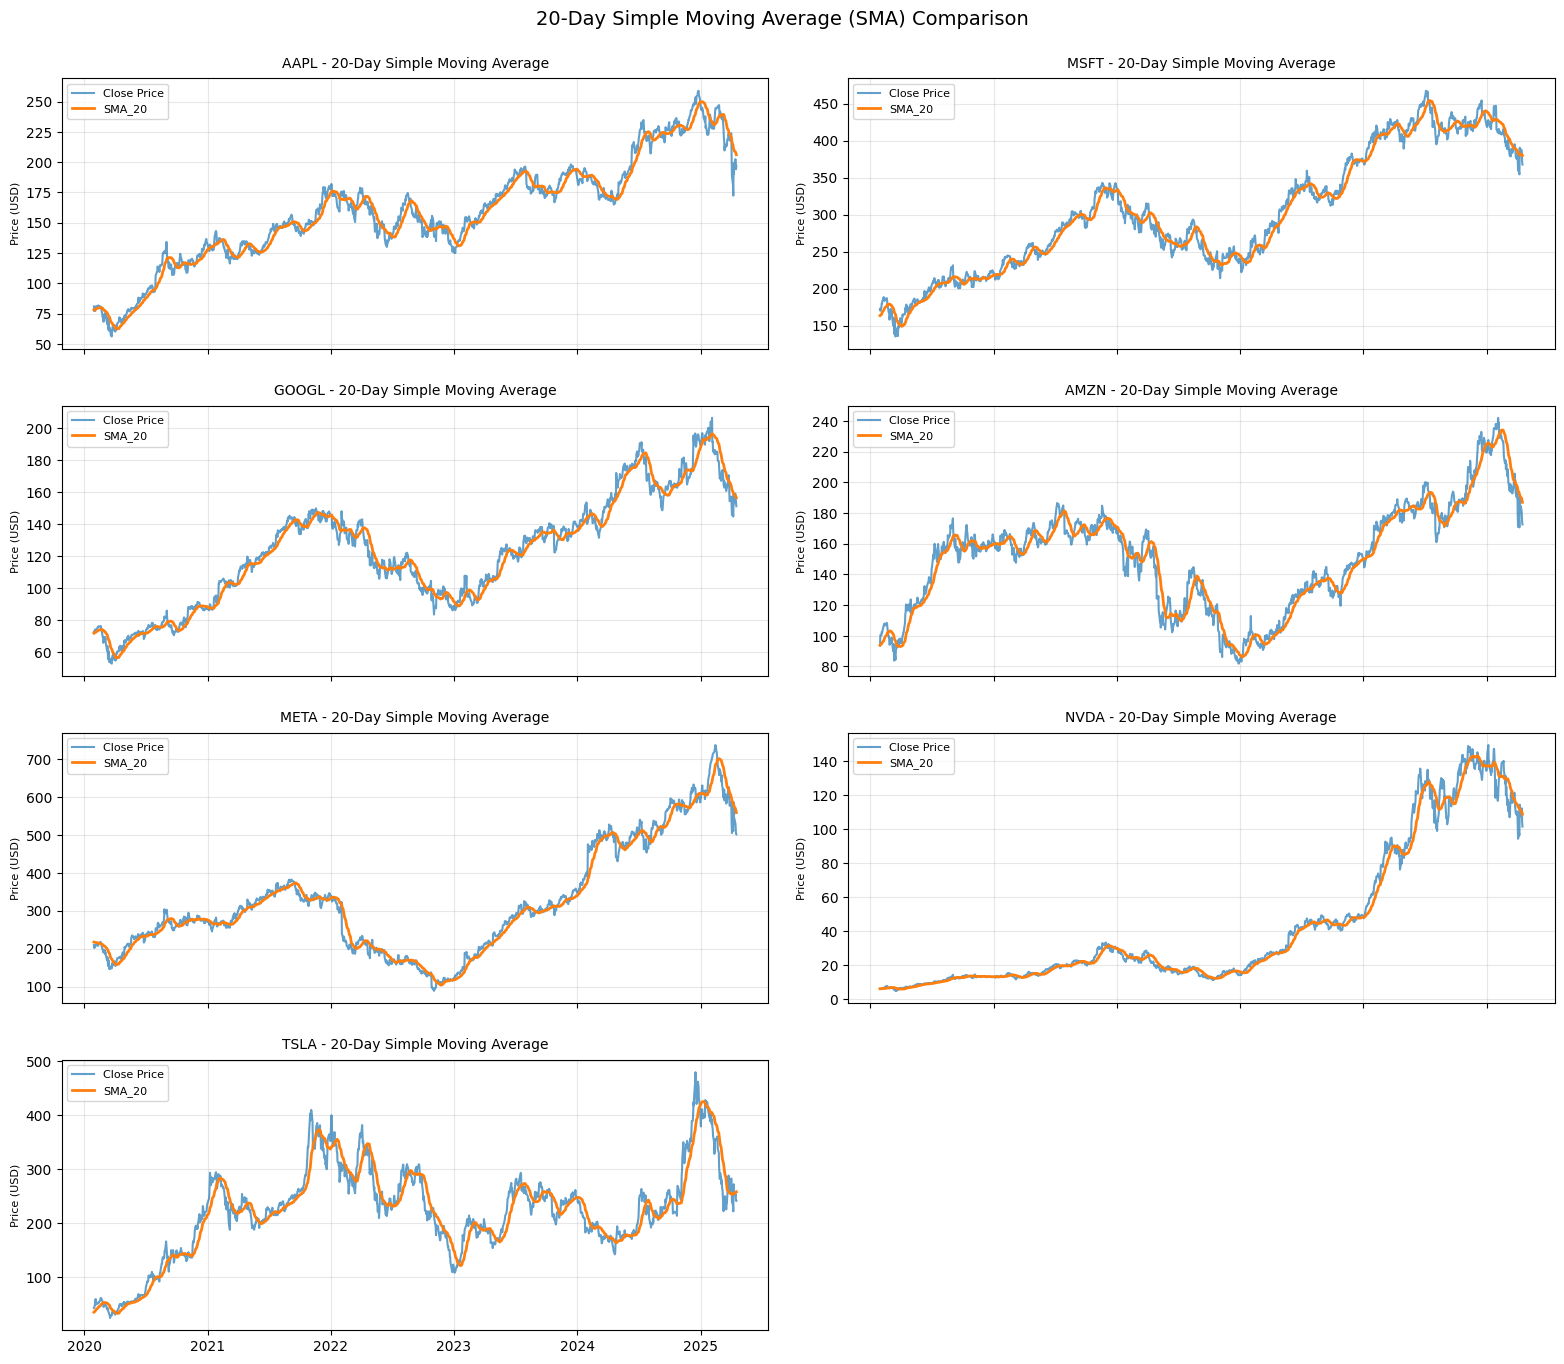

In [8]:
# filter NaNs
df_viz = df_transformed.dropna(subset=['SMA_20'])

# create 4x2 grid subplots 
fig, axes = plt.subplots(4, 2, figsize=(16, 14), sharex=True)
axes = axes.flatten()  
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

# plot for each ticker (7 subplots)
for i, ticker in enumerate(tickers):
    data = df_viz[df_viz['Ticker'] == ticker]
    
    # plot Closing Price and SMA_20 with valid hex colors
    axes[i].plot(data['Date'], data['Close'], label='Close Price', 
                color='#1f77b4', alpha=0.7)  
    axes[i].plot(data['Date'], data['SMA_20'], label='SMA_20', 
                color='#ff7f0e', linewidth=2)  
    
    axes[i].set_title(f"{ticker} - 20-Day Simple Moving Average", fontsize=10, pad=8)
    axes[i].set_ylabel('Price (USD)', fontsize=8)
    axes[i].grid(True, alpha=0.3)
    axes[i].legend(loc='upper left', fontsize=8)

# hiding the empty 8th subplot
axes[7].axis('off')

# setting common labels and title
plt.xlabel('Date', fontsize=10)
plt.suptitle('20-Day Simple Moving Average (SMA) Comparison', fontsize=14, y=0.98)
plt.tight_layout(pad=2.0)  
plt.show()

This graph gives a comparative analysis of the 20-day Simple Moving Average for our 7 major stocks. Each subplot overlays the daily closing price (blue) with the 20-day SMA (orange) starting from 2020 through 2025. 

The 20-day SMA smooths out short-term fluctuations and highlights intermediate trends by averaging the past 20 days of closing prices. SMA is used by traders to identify bullish or bearish trends, signal reversals (when price crosses SMA), or to confirm momentum (consistent divergence or convergence).

- **AAPL**: The price closely follows the SMA, showing moderate but consistent growth. Periods where price drops below SMA are typically followed by recoveries, indicating healthy consolidation rather than steep corrections. 
- **MSFT**: Their SMA reflects strong long-term growth with periodic corrections. It follows the price tightly, indicating low volatility and astable upward momentum. 
- **GOOGL**: Their SMA appears slightly more volatile than AAPL/MSFT, there are sharp downtrends visible in 2022 and early 2025 (where the SMA lags behind fast drops).
- **AMZN**: There is noticable choppiness and range-bound behavior in this SMA compared to the others. It crosses the price more frequently, inidcating uncertainty or sideways movement in some periods. 
- **META**: Their SMA displays significant dip and recovery cycles. I=There is a large dovergence between price and SMA during peacks (2024-2025) suggesting sharp speculative movements. 
- **NVDA**: This SMA shows steep exponential growth (especially post-2023), it lags behind big rallies and corrections, highlighting extreme volatility and rapid trend shifts. 
- **TSLA**: Their SMA show high volatility with multiple spikes and corrections. There are large oscillations between price and SMA indicate speculative surges and momentum-driven price action. 

## SMA Visualization with candlestick graph

In [9]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

positions = [(1, 1), (1, 2), (2, 1), (2, 2), (3, 1), (3, 2), (4, 1)]

# making 4x2 subplot grid
fig = make_subplots(
    rows=4,
    cols=2,
    shared_xaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.05,
    subplot_titles=[f"{ticker} Candlestick with SMA(20)" for ticker in tickers] + [""],
    specs=[[{}, {}], [{}, {}], [{}, {}], [{}, {}]]
)

# looping through each ticker and its subplot position
for idx, ticker in enumerate(tickers):
    row, col = positions[idx]
    subset = df_transformed[df_transformed['Ticker'] == ticker]

    # add candlestick trace
    fig.add_trace(go.Candlestick(
        x=subset['Date'],
        open=subset['Open'],
        high=subset['High'],
        low=subset['Low'],
        close=subset['Close'],
        name='Price',
        showlegend=False
    ), row=row, col=col)

    # add SMA_20 line trace
    fig.add_trace(go.Scatter(
        x=subset['Date'],
        y=subset['SMA_20'],
        line=dict(color='blue', width=1.5),
        name='SMA_20',
        showlegend=False
    ), row=row, col=col)

# hiding the unused bottom-right subplot 
fig.update_xaxes(visible=False, row=4, col=2)
fig.update_yaxes(visible=False, row=4, col=2)

# hide rangesliders on all but last row
for row in [1, 2, 3]:
    for col in [1, 2]:
        fig.update_xaxes(rangeslider_visible=False, row=row, col=col)

fig.update_layout(
    height=1000,
    width=900,
    title_text="Candlestick Charts with SMA(20) Comparison",
    template="plotly_white",
    margin=dict(t=100),
    xaxis7_rangeslider=dict(visible=False)
)

fig.show()

This graph has the same data as the previous, but displayed with a candlestick chart instead of a line graph. 

Candlestick graphs are especially useful because they show the open, high, low, and close for each day (green for up days and red for down days). This style of graph adds details about daily volatility, intrday movement, and price actions patterns. 

## RSI

In [10]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]
cols = 2
rows = (len(tickers) + 1) // cols

# creating subplot figure with titles
fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=[f"{ticker} RSI(14)" for ticker in tickers]
)

# plotting RSI for each ticker
for idx, ticker in enumerate(tickers):
    row, col = divmod(idx, cols)
    row += 1  
    col += 1

    subset = df_transformed[df_transformed['Ticker'] == ticker]

    # RSI line
    fig.add_trace(
        go.Scatter(
            x=subset['Date'],
            y=subset['RSI_14'],
            line=dict(color='purple', width=1.5),
            name=f"{ticker} RSI"
        ),
        row=row, col=col
    )

    # overbought and oversold threshold lines
    fig.add_hline(y=70, line_dash="dot", line_color="red", row=row, col=col)
    fig.add_hline(y=30, line_dash="dot", line_color="green", row=row, col=col)

fig.update_layout(
    height=400 * rows,
    width=1200,
    title_text="RSI (14-period) Analysis",
    template="plotly_white",
    showlegend=False
)
fig.update_yaxes(range=[0, 100]) 

fig.show()

RSI is a momentum oscillator (ranging from 0 to 100), it measures the speed and magnitude of recent price changes to identify overbought or oversold conditions. The potential sell signal is at the above 70 threshold, which means it is overbought. The potential buy signal is at the below 30 threshold, which means it is oversold. The horizontal red line at 70 and green line at 30 represents these boundaries. 
- **AAPL**: Their RSI frequently spikes above 70 and dips below 30. This indicates short bursts of momentum in both directions, likely tied to earnings or news cycles. There is a fair balance between overbought and oversold periods which means it has a healthy trade range. 
- **AMZN**: This RSI spends less time in the overbought zone compared to AAPL. There are more frequent dips near or below 30, showing periods of weakness or potential buying opprotunities. Their graph suggests more bearish pressure or clower recoveries. 
- **GOOGL**: Their RSI shows very frequent oscillations between the extremes. It often hovers in the mid-range but regularly breaks the 70/30 thresholds, indicating high short-term trading activity. Therefore, their volatility and trader interest are high, but with balanced momentum. 
- **META**: This RSI tends to dip below 30 more often than going above 70 (especially in 2022-2023). This suggests periods of consistent pressure, with a few sharp recovery periods. This indicates more downward than upward momentum in recent years. 
- **MSFT**: Their RSI shows a strong, stable range, with most values clustering around 40-70. This less frequent extreme values mean lower volatility. Their stability implies sustained institutional support or steady growth perception. 
- **NVDA**: This RSI is one of the more volatile RSI patterns of the 7. High spikes above 70 and sharp drops below 30 reflect speculative trading, momentum surges, and frequent buy/sell opprotunities. Thhis is consistent with NVDA's reputation for being sensitive to market swings (high beta behavior).
- **TSLA**: Tesla's RSI shows rapid swings, reaching extreme levels frequently. They have very trader-driven stock, reflecting hype cycles, earning shocks, or news events. This persistent volatility implies high risk, high reqard. 

## MCAD Visualization

In [11]:
# create box plot
fig = px.box(
    df_transformed,
    x='Ticker',
    y='MACD',
    color='Ticker', 
    title='MACD Distribution by Ticker',
    labels={'Ticker': 'Ticker', 'MACD': 'MACD Value'},
    template='plotly_white'
)

fig.update_layout(
    yaxis_title='MACD Value',
    xaxis_title='Ticker',
    hovermode='x unified',
    showlegend=False  
)

fig.add_hline(
    y=0,
    line_dash="dot",
    line_color="gray",
    annotation_text="Zero Line",
    annotation_position="bottom right"
)

fig.show()

The MACD is a trend-following momentum indicator that shows the relationship between two moving averages (12 and 26 period EMAs). An MACD above 0 is bullish momentum, while an MACD below 0 is bearish momentum. The zero line is the key pivot point. 
- **AAPL**: Apple's median MACD is just above 0, displaying a balanced, moderate spread. This shows a mild positive bias and a stavle bullish momentum. 
- **AMZN**: Amazon's median MACD is slightly above 0, displaying a moderate-high volatility and a slightly negative skew. This indicates some bullish periods but frequent dips, suggesting coppy price action. 
- **GOOGL**: Google's median MACD is close to 0, indicating a low-moderate spread and volatility. It's balance also implies a tight distribution, indicating steady but limited swings and less volatility. 
- **META**: Meta's median MACD is arounf 0 with a very wide sprad and colatility. Its balance implies it is highly volatile, with strongup/down MACD swings, suggesting aggresive market responses. 
- **MSFT**: Microsoft has a median MACD above 0, with a moderate-high spread and volatility, and a slightly positive skewness. This implies a bullish skew, with stronger upwards trends over time. 
- **NVDA**: Nividia's median MACD is centered on 0, it has the tightest spread and volatility of all the stocks and has a balanced skewness. This implies that despite Nividias price volatility, their MACD stays in check, indicating momentum is more controlled than price action suggests. 
- **TSLA**: Tesla's median MACD is around 0, with an extreme spread and volatility and balanced skewness. Tesla has the most volatile MACD, with wide swings above and below zero, reflecting Tesla's highly speculative and reactive behavior. 

Interesting Observations: 
- META and TSLA have the widest ranges, indicating significant fluctuations in momentum and many crossovers of the zero line 
- NVDA is suprisingly stable in MACD despite volatile price movement, suggesting theur MACD may lag during sharp surges. 
- MSFT stands out with a clear upward momentum bias, making it a stringer candidate for trend-following strategies 
- AAPLY and GOOGL offer consistent, predictable behavior, suitable for low-risk momentum trading. 
- Long-term trend followers perfer MSFT, AAPL, and GOOGL
- Volatility traders look to TSLA and META, while momentum-neutral traders consider NVDA

## Bollinger Bands Visualization 

In [12]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

positions = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2), (4,1)]

# creating 4x2 subplot figure
fig = make_subplots(
    rows=4,
    cols=2,
    shared_xaxes=True,
    vertical_spacing=0.05,
    horizontal_spacing=0.08,
    subplot_titles=[f"{ticker} Bollinger Bands" for ticker in tickers],
    specs=[[{}, {}], [{}, {}], [{}, {}], [{}, {}]]
)

for idx, ticker in enumerate(tickers):
    row, col = positions[idx]
    subset = df_transformed[df_transformed['Ticker'] == ticker]

    # Candlestick
    fig.add_trace(go.Candlestick(
        x=subset['Date'],
        open=subset['Open'],
        high=subset['High'],
        low=subset['Low'],
        close=subset['Close'],
        name='Price',
        showlegend=False
    ), row=row, col=col)

    # Bollinger Bands
    fig.add_trace(go.Scatter(
        x=subset['Date'],
        y=subset['BB_Upper'],
        line=dict(color='gray', width=1),
        name='Upper Band',
        showlegend=False
    ), row=row, col=col)

    fig.add_trace(go.Scatter(
        x=subset['Date'],
        y=subset['BB_Lower'],
        line=dict(color='gray', width=1),
        fill='tonexty',
        name='Lower Band',
        showlegend=False
    ), row=row, col=col)

# hiding the unused subplot 
fig.update_xaxes(visible=False, row=4, col=2)
fig.update_yaxes(visible=False, row=4, col=2)

# turning off range sliders on all but bottom row
for row in [1, 2, 3]:
    for col in [1, 2]:
        fig.update_xaxes(rangeslider_visible=False, row=row, col=col)

fig.update_layout(
    height=1200,
    title_text="Bollinger Bands Comparison",
    template="plotly_white",
    margin=dict(t=100),
    xaxis7_rangeslider=dict(visible=False)
)

fig.show()

To visualize Bollinger Bands, each plot overlays the closing price with upper and lower limits, which are shaded around a moving average. The base of these graphs is the SMA candlestick graph, while the upper band is SMA+2 standard deviations, and the lower band is SMA-2 standard deviations. The bands contract during low volatility and expand during high volatility. Price touching and extending beyond the bands suggest overbought or oversold conditions. 
- **AAPL**: Apple has steady spacing band behavior. Its volatility pattern has period expansions (late 2023, 2025). This moderate, cyclical volatility is good for trend trading. 
- **AMZN**: Amazon's band behavior has noticable squeezes and expansions. Its volatility pattern has sharp expansions mid-2023 and early 2025. This suggests strong directional moves after compressions, which is suitable for breakout trading. 
- **GOOGL**: Google's band behavior has smooth bands with some mild contractions. Its bands expand with trends, and compress in flat markets. This graph reflects stable but tradable swings with a potential for swing strategies. 
- **META**: Meta's band behavior has wide bands during big price swings (2024-2025) with frequent large expansions in volatility. This indicates high volatility and momentum-driven movement. This is good for aggresive short-term trading.
- **MSFT**: Microsoft's band behavior has consistent bands with few extreme breakouts. They have low volatility relative to others. This graph suggests predictable, stable growth, with less frequent trade signals (but lower risk). 
- **NVDA**: Mividia has sharp band expansions (notably in 2023). Their volatility pattern exhibits massive breakouts followed by consolidation. Therefor, Nividia is excellent for volatility trading. 
- **TSLA**: Tesla has the most dramatic band widening, with frequent large spikes and compressions. This indicates high volatility and price swings, this is ideal for volatility breakout setups (but is riskier). 

## Moving Average Crossover Chart

In [13]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]
positions = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2), (4,1)]

# create subplots
fig = make_subplots(
    rows=4,
    cols=2,
    shared_xaxes=True,
    vertical_spacing=0.08,
    horizontal_spacing=0.08,
    subplot_titles=[f"{ticker} MA Crossover" for ticker in tickers],
    specs=[[{}, {}], [{}, {}], [{}, {}], [{}, {}]]
)

# SMA and EMA traces
# SMA and EMA traces with legend only on first subplot
for idx, ticker in enumerate(tickers):
    row, col = positions[idx]
    subset = df_transformed[df_transformed['Ticker'] == ticker]

    show_legend = (idx == 0)  # Only show legend for the first ticker

    # SMA_20
    fig.add_trace(go.Scatter(
        x=subset['Date'],
        y=subset['SMA_20'],
        name='SMA 20',
        line=dict(color='blue', width=1.5),
        showlegend=show_legend
    ), row=row, col=col)

    # EMA_20
    fig.add_trace(go.Scatter(
        x=subset['Date'],
        y=subset['EMA_20'],
        name='EMA 20',
        line=dict(color='red', width=1.5),
        showlegend=show_legend
    ), row=row, col=col)

# hiding the unused subplot 
fig.update_xaxes(visible=False, row=4, col=2)
fig.update_yaxes(visible=False, row=4, col=2)

fig.update_layout(
    height=1200,
    title_text="Moving Average Crossover Comparison",
    template="plotly_white",
    margin=dict(t=100),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()


A Moving Average Crossover Comparison graph charts the 20-day SMA (blue line) and 20-day EMA (orange line). When the EMA crosses above the SMA, it is often considered a bullish signal (momentum is accelerating). When the EMA crosses below the SMA, this is often seen as bearish (momentum is weakening). The EMA is more responsive to recent price movements due to exponential weighting, while the SMA is smoother and lags more. 
- **AAPL**: Apple has frequent crossover activity, with a slight lead-lag between EMA and SMA. The smoothing behavior shows a very close alignment. This indicates stable momentum, suitable for medium-term trend following.
- **AMZN**: Amazon's crossover activity has slightly more divergence, especially in volatile phases. The smoothing behavior makes the EMA lead noticably during surges. This graph is useful for spotting momentum changes early, but it's slightly more volatile. 
- **GOOGL**: Google has a clean crossover activity, especially during corrections. The smoothing behavior is a good visual confirmation of trend shifts. This graph indicates that Google is effective for swing trades and reversals. 
- **META**: Meta has large crossover activity during steep up/down phases. The smoothing behavior makes EMA more reactive. This graph reflects high volatility trading conditions, and the EMA helps catch early moves. 
- **MSFT**: Microsoft's crossover activity exhibits a very small gap between EMA and SMA. The smoothing behavior displays low volatility, and fewer sharp crossovers. This indicates market confidence (the EMA rarely strays from SMA), which is good for steady accumulation strategies. 
- **NVDA**: Nividia's crossover activity shows noticable separation during bull runs (when stocks rise in value year after year over a long period of time). Their EMA significantly leads SMA. This graph is good for identifying early-stage trends, especially after consolidation (momentum indicator). 
- **TSLA**: Tesla has very wide divergences at spikes for crossover activity. Their EMA leads strongly. This graph suggests high responsiveness which is critical for trading (SMA is too slow in extreme moves). 

Key Comparisons: 
- Stocks like TSLA, META, and NVDA benefit from EMA's sensitivity, eneabling wuicker entry/exit in volatile markets. 
- Stocks like APPL and MSFT move more predictavly, so crossovers are less frequent but more reliable. 

## Volume-Weighted Average Price (VWAP)

In [14]:
# computing the typical price
df_transformed['Typical_Price'] = (df_transformed['High'] + df_transformed['Low'] + df_transformed['Close']) / 3

# grouped VWAP
df_transformed['VWAP'] = df_transformed.groupby('Ticker', observed=True).apply(
    lambda g: (g['Typical_Price'] * g['Volume']).cumsum() / g['Volume'].cumsum(), include_groups=False
).reset_index(level=0, drop=True)


tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]
n = len(tickers)

# grid size (e.g., 2 columns)
cols = 2
rows = math.ceil(n / cols)

# making subplots
fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=[f"{ticker} VWAP Analysis" for ticker in tickers],
    shared_xaxes=False,
    shared_yaxes=False,
    vertical_spacing=0.05,
    horizontal_spacing=0.05
)

# graphing line plots to each subplot
for i, ticker in enumerate(tickers):
    row = i // cols + 1
    col = i % cols + 1
    subset = df_transformed[df_transformed['Ticker'] == ticker]
    
    fig.add_trace(
        go.Scatter(x=subset['Date'], y=subset['Close'], mode='lines', name='Close',line=dict(color='blue'), 
        showlegend=(i == 0)),
        row=row, col=col
    )
    fig.add_trace(
        go.Scatter(x=subset['Date'], y=subset['VWAP'], mode='lines', name='VWAP',line=dict(color='orange'),  
        showlegend=(i == 0)),
        row=row, col=col
    )

fig.update_layout(
    height=300 * rows,
    title_text="VWAP vs Close Price Comparison",
    template="plotly_white",
    showlegend=True  
)

fig.show()

Volume Weighted Average Price (VWAP) reflects the average price of a stock, weighted by volume. It's widely used by institutional traders to evaluate whether a stock was bought above or below average market price. 

A price above VWAP indicates possible overbuying, a price below VWAP indicates possible underevaluation or sell pressure. 
A VWAP equal to close price indicates fair pricing and a balanced market. A VWAP greater then the close price suggests the volume was heavier at higher prices, indicating a possible bullish trap or correction. A VWAP less than close price suggests upward momentum not yet matched by volume. 
- **AAPL**: Apple has a Close Price that consitently stays above the VWAP, indicating strong bullish momentum. This could be interpreted as continued demand, pushing the stock price higher than its volume-weighted average.  
- **AMZN**: Amazon fluctuates around the VWAP more than our other tickers. Its crossing behavior suggests more volatility and less clear momentum, indicating alternating cycles between accumulation and distribution.  
- **GOOGL**: Google's price stays relatively close to the VWAP, but mostly above it. This indicates a more moderate bullish behavior, indicating market indecision. 
- **META**: Meta see's a significant dip in early 2022 where Close falls below VWAP, followed by a strong recovery. This indicates a period of heavy sell-off followed by institutional interest, causing a rebound. 
- **MSFT**: Similar to Apple, Microsoft maintains a price trend mostly above VWAP, signifying a bullish long-term trend. It does have periods where Close dips near VWAP,, which could signal temporary corrections. 
- **NVDA**: Nvidia see's a dramatic rise in price in late 2023-2024, where the Close price is far above the VWAP. This relfects a sharp bullish breakout, often seen in growth or hype-driven periods. 
- **TSLA**: Tesla shows high colatility, with several sharp peaks and correctins. Their Close remains above VWAP for most of the time, but its erratic nature suggests a trader-driven market rather than a stable institutional holding. 

## Correlation Heatmap

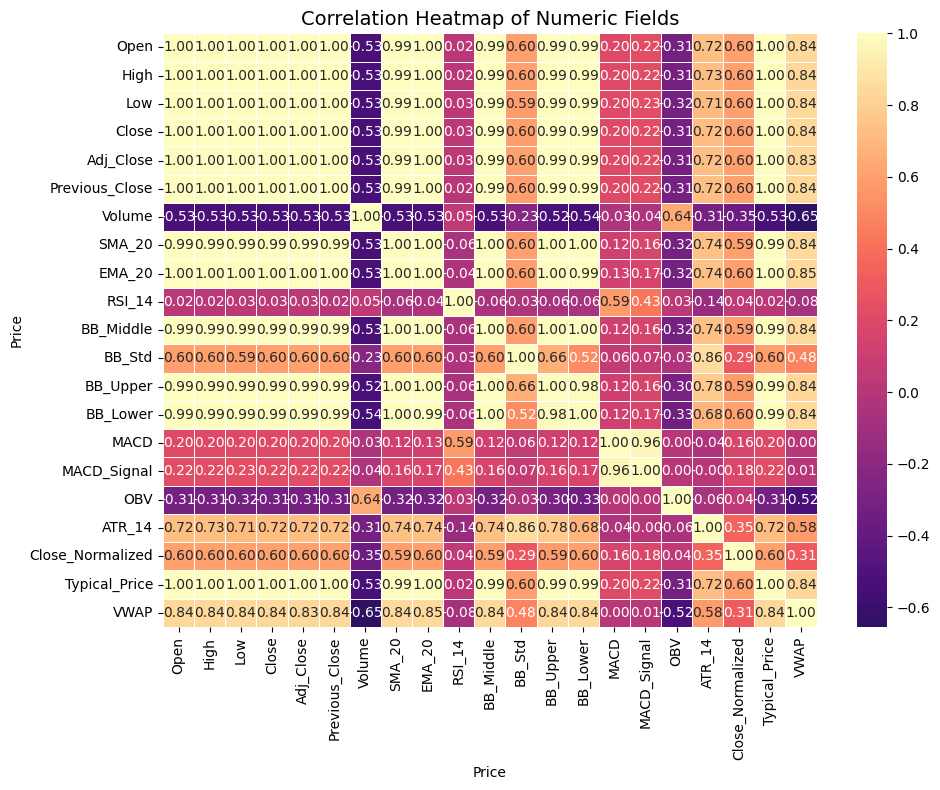

In [15]:
numeric_df = df_transformed.select_dtypes(include='number')  
corr_matrix = numeric_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='magma', fmt=".2f", center=0, linewidths=0.5)
plt.title('Correlation Heatmap of Numeric Fields', fontsize=14)
plt.tight_layout()
plt.show()

Highly Correlated Groups: 
- Price-related variables (Open, High, Low, CLose, Adj_Close, Previous_Close) all have perfect or near perfect correlation (~1.00). This is expected since they are derived from the same source.
- Trend indicators (SMA_20, EMA_20, BB_Middle, BB_Upper, BB_Lower) have a very strong positive correlation with each other and with Close since they track price direction 
- VWAP shows a moderate to strong correlation with Volume (0.93) and Close (0.47). This indicates that VWAP is volume-weighted but still follows price trends. 

Moderately Correlated Variables: 
- Atr_14 correlates moderately with Volume (0.64) abd Close (0.73). This suggests volatility rises with price and volume spikes. 
- BB_Std shows moderate correlation (0.59) with Close. This reflects volatility more than trend, which is useful for detecting breakouts. 

Weak/Uncorrelated Features: 
- RSI_14 has a weak correlation with most price metrics, indicating it as a momentum oscillator. It doesn't track price directly and adds diversity to feature set. 
- MACD, MACD_Signal has a weak to moderate correlation with price. This implies it is good for detecting trend strength, but not linear correlation with price. 

Negative Correlation: 
- VWAP, MACD, Close_Normalized has a negative correlation with Open and High. This likely reflects inverse movements or scale differnces in the dataset. 

## Cumulative Returns Comparison

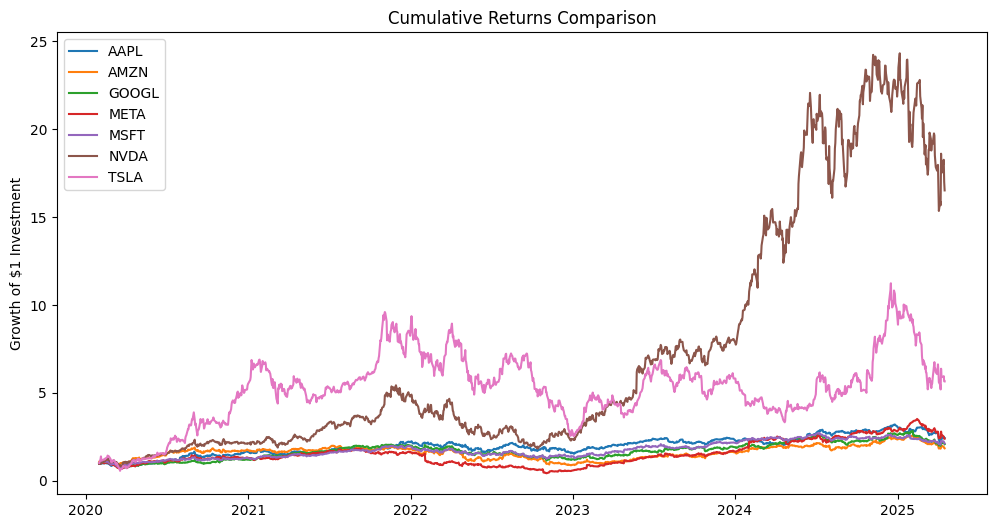

In [16]:
# Calculate cumulative returns
close_prices = df_transformed.pivot(index='Date', columns='Ticker', values='Close')
cumulative_returns = close_prices.pct_change().add(1).cumprod()

plt.figure(figsize=(12,6))
for ticker in cumulative_returns.columns:
    plt.plot(cumulative_returns.index, cumulative_returns[ticker], label=ticker)
plt.title('Cumulative Returns Comparison')
plt.ylabel('Growth of $1 Investment')
plt.legend()
plt.show()

Cumulative returns represent the total gain or loss on investment over the period 2020-2025. All stocks start with a normalized investment of $1 and show how that investment would grow over time. This type of chart is often used to compare long-term performance and volatility. 
- **NVDA**: Nvidia grows up to 25 times its investment, this very high volatility makes this stock the best performer of the 7. It shows explosive growth (especially from late 2023-2024), possibly reflecting the booming AI?semiconductor demand. 
- **TSLA**: Tesla peaks at 11x and ends around 7x original investment. Tesla has a very high volatility. In early 2021 tesla has a rapid surge, followed by long waves of boom and bust. It is highly speculative with strong momentum surges. 
- **MSFT**: Microsoft's investment ends around 2.5 times original investment. Its low volatility shows steady and reliable growth, with less upside but less drawdown. this graph is a great examle of a blue-chip compounding stock. 
- **AAPL**: Apple's cumulative returns ends just below Microsoft, and it also has a low volatility. This shows that Apple is consistent and resilient, even in downturns. It performs best among mid-teir performers. 
- **GOOGL and AMZN**: Google and Amazon perform very close together, but with modest growth and moderate volatility. Their relatively muted returns compared to the others may reflect consolidation periods or less speculative trading. 
- **META**: Meta has had a flat/negative return until late 2024, followed by a modest recovery with medium volatility. They underperformed until late in the period, possibly due to regulatory/news sentiment. But they have had a recent surge indicating rebound potential.

Key Observations: 
- NVDA has the highest cumulative return, likely driven by exponential growth and investor enthusiam around AI. 
- TSLA had a strong early lead, but its performance is erratic, indicating high risk and reward. 
- The rest of the stocks are relatively clustered, with MSFT and AAPL leading as low-volatility, steady growers.
- META was the weakest performer until a late-stage improvement. 

What this tells us about investment: 
- Long-term growth: NVDA, MSFT, AAPL
- Speculative movement: TSLA
- Mean reversion/value play: META
- Diversified core holding: MSFT, AAPL
- Volatility-sensitive strategy: Avoid TSLA/NVDA unless hedged

## Volume Analysis 

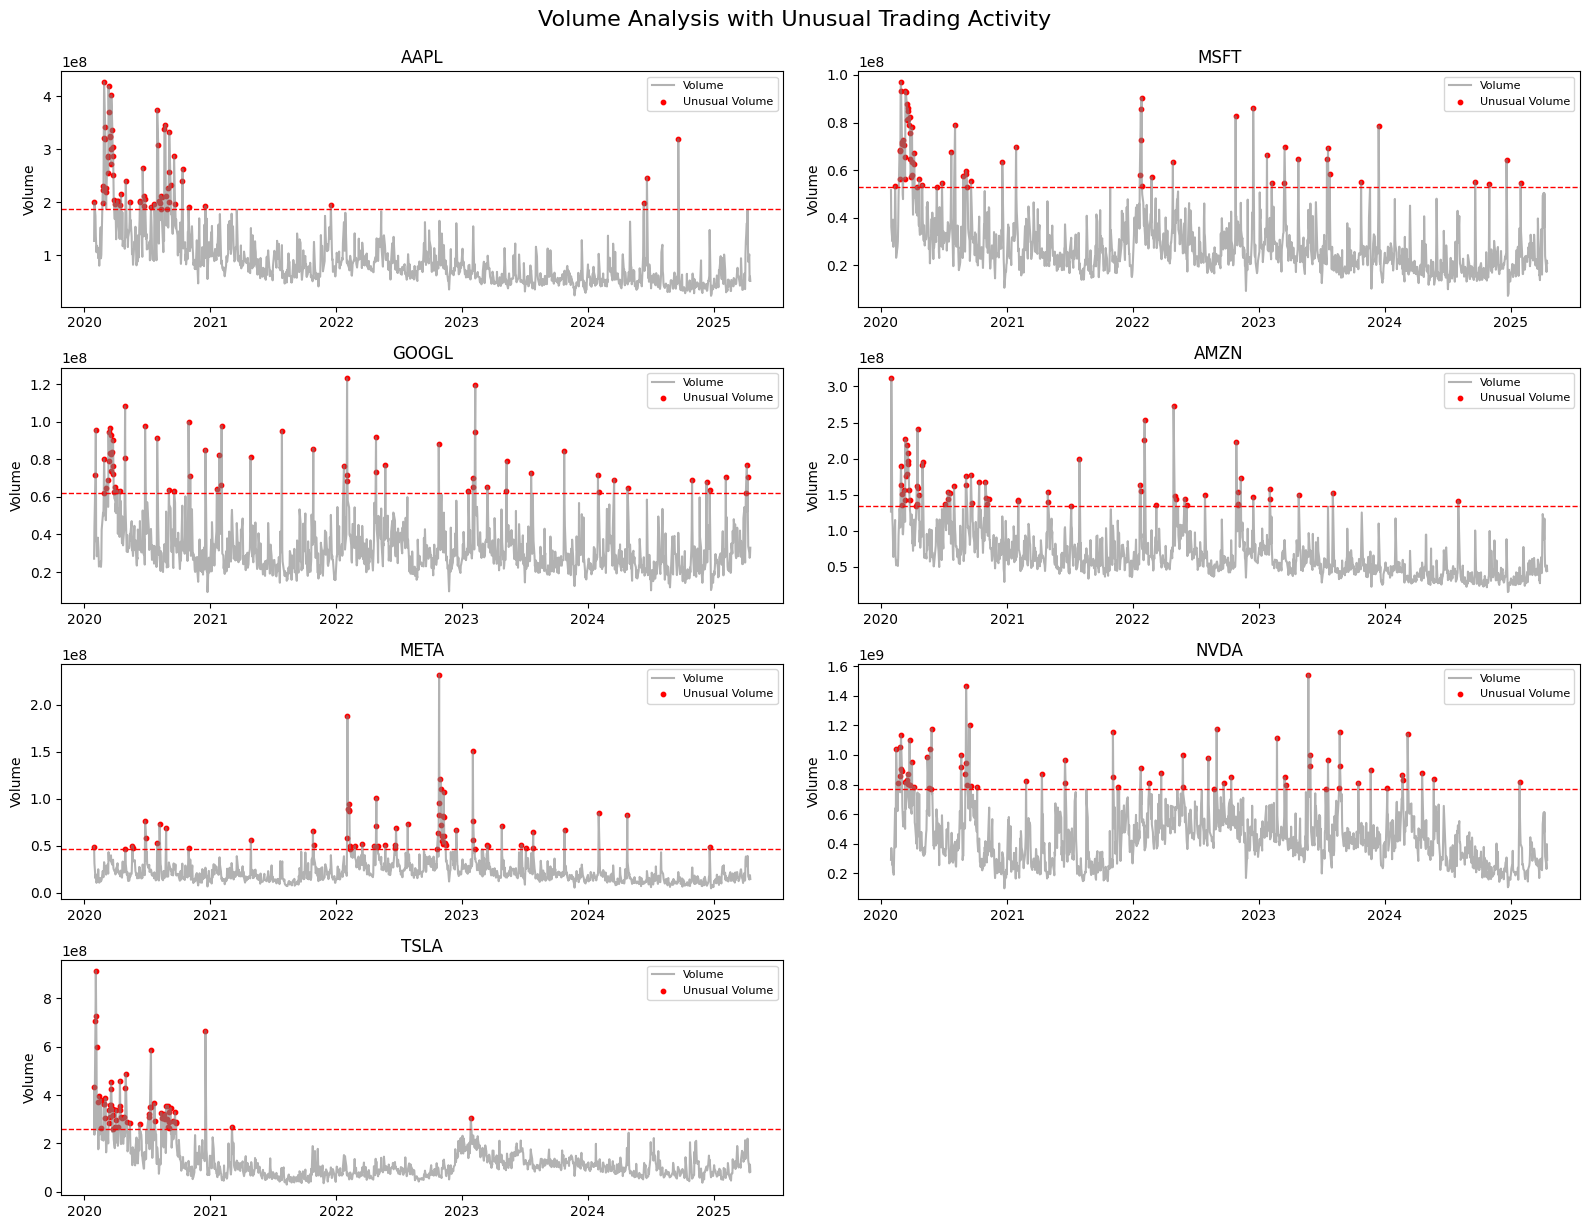

In [17]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, ticker in enumerate(tickers):
    ax = axes[i]
    
    df_ticker = df_transformed[df_transformed['Ticker'] == ticker].sort_values('Date')
    
    volume_threshold = df_ticker['Volume'].quantile(0.95)
    
    ax.plot(df_ticker['Date'], df_ticker['Volume'], label='Volume', color='gray', alpha=0.6)
    
    unusual = df_ticker['Volume'] > volume_threshold
    ax.scatter(df_ticker['Date'][unusual], df_ticker['Volume'][unusual], 
               color='red', label='Unusual Volume', s=10)
    
    ax.axhline(volume_threshold, color='red', linestyle='--', linewidth=1)
    ax.set_title(ticker)
    ax.set_ylabel('Volume')
    ax.legend(fontsize=8)

fig.delaxes(axes[-1])

plt.tight_layout()
plt.suptitle("Volume Analysis with Unusual Trading Activity", fontsize=16, y=1.02)
plt.show()

This chart is used to display Volume Analysis with Unusual Trading Activity from 2020 to 2025. The **gray line** plots daily trading volume while the **red dots** point to where volume exceeds a defined unusual activity threshold (a moving average + standard deviations). The **red line** represents the threshold for unusual volume. 

This type of graph is used to identify spikes in trading volume often correlated with earning reports, product launches/failures, marketwide events, or insider transactions/institutional moves. 
- **AAPL**: Apple shows many spikes in 2020, but is aprse after. Their volume stabalizes at a low baseline. Their early surge was likely pandamic related, followed by a calm institutional flow, an indicator of efficient market behavior. 
- **MSFT**: Microsoft shows scattered spikes that are evenly spread. Their volume is slightly more variable. This reflects reactive institutional trades, possibly to quarterly results, but it is overall well balanced. 
- **GOOGL**: Google exhibits heavy early spikes that thin later. Their volume also decreases overtime. This graph suggests a front-loaded trading interest, possibly tied to pre-2022 news or catalysts. 
- **AMZN**: Amazon shows strong spikes in 2020-2021 but fewer later. They exhibit a volume trend similar to Google. Their early volatility is likely die to the e-commerce surge, tapering in later years. 
- **META**: Meta sees the most spikes around 2021-2023. They exhibit irregular volume peaks. They have periods of news-driven uncertainty, suggesting restructuring or major transitions (possibly the Metaverse switch late-2021). 
- **NVDA**: Nvidia has unusual spikes throught their plot, with a sustained high volume baseline. This indicates constant trading activity and ongoing speculative/institutional interest.
- **TSLA**: Tesla has larger spikes clustered in 2020-2021, then becomes quiet. It has a very high early volume. Tesla's 'hype cycle' and 'meme stock' status fueled early volume spikes, with later trading normalization. 

Noteworthy Patterns:
- APPL and MSFT reflect stable, institutional-grade trading post-2021, with less noise and more predictability. 
- META and NVDA show continued trading interest across time, suggesting they are news-sensitive.
- TSLA has the most dramatic early activity, which is a signature of a retail-dominated rally.
- GOOGL and AMZN have early volume fades which indicate diminishing retail/institutional excitement or price stability. 

## Volatility Analysis (ATR)

In [18]:
tickers = ["AAPL", "MSFT", "GOOGL", "AMZN", "META", "NVDA", "TSLA"]

fig = make_subplots(rows=4, cols=2, subplot_titles=[f"{t} ATR(14)" for t in tickers])

# loop and fill subplots
for i, ticker in enumerate(tickers):
    subset = df_transformed[df_transformed['Ticker'] == ticker]
    positions = [(1,1), (1,2), (2,1), (2,2), (3,1), (3,2), (4,1)]
    row, col = positions[i]

    fig.add_trace(
        go.Scatter(x=subset['Date'], y=subset['ATR_14'], name=ticker, mode='lines'),
        row=row, col=col
    )

# removing empty 8th plot if needed
if len(tickers) < 8:
    fig.update_layout(showlegend=False)
else:
    fig.update_layout(height=1000, showlegend=False)

fig.update_layout(
    title="Volatility Analysis (ATR 14) Across Tickers",
    height=900,
    width=1000
)

fig.show()

ATR(14) is a volatility indicator that measures the average range between high and low prices over the last 14 days. A higher ATR means more volatility, while a lower ATR signifies calmer price action. ATR does not indicate trend direction, only the magnitude of price movement. ATR analysis gives great insight into how aggressively a stock is moving, even is the direction isn't clear. 
- **APPL**: Apple has cyclical rises in 2020 and late 2023-2025. It has noticable peaks near earnings or market stress. In this graph we see controlled volatility cycles, suitable for dwing trading.
- **AMZN**: Amazon has a gradual ATR rise post-2022 with its latest spike in 2025. their rising volatality may reflect restructuring or shifiting market view. 
- **GOOGL**: Google's ATR is relatively flat until 2024, then has a gradual rise, but an overall low volatility. this suggests that Google is good for stable long-term holding or low-risk stretegies. 
- **META**: Meta has a low ATR until 2023, then a steep climb with spikes in 2024-2025. This suggests recovery from underperformance or major structural/event-driven moves. 
- **MSFT**: Microsfot spiked early in 2020, then remains consistently moderate with a sustained range of 5-10. This reflects institutional confidence, offering predictable trade ranges. 
- **NVDA**: Nvidia has a low ATR until late 2022, then changes to an exponential rate with a sharp spike in late 2024. This tracks closely with price breakout behavior-momentum trading. 
- **TSLA**: Tesla has a high ATR from the start, then mid-range with a resurgence in 2025 with peaks in 2021 and 2025. Tesla remains the most volatile stock overall, consistent with speculative interest. 

Main Observations:
- TSLA and META show the highest ATR values, suggesting aggressive price movement and trading opprotunity (but with higher risk).
- NVDA's ATR spike aligns with its explosive growth, confirming ATR as an early volatility signal
- GOOGL is the most consistent low-volatility stock in the group. 
- MSFT and APPL reflect market maturity and institutional steadiness, ideal for structured trading systems. 

## MACD

In [19]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np

tickers = df_transformed['Ticker'].unique()
rows = 4
cols = 2

fig = make_subplots(
    rows=rows,
    cols=cols,
    subplot_titles=[f"{t} MACD" for t in tickers],
    shared_xaxes=True,
    vertical_spacing=0.08
)

for i, ticker in enumerate(tickers):
    row = i // cols + 1
    col = i % cols + 1
    subset = df_transformed[df_transformed['Ticker'] == ticker]

    # MACD bars
    fig.add_trace(
        go.Bar(
            x=subset['Date'],
            y=subset['MACD'],
            marker_color=np.where(subset['MACD'] < 0, 'red', 'green'),
            name=f"{ticker} MACD",
            showlegend=False
        ),
        row=row, col=col
    )

    # MACD signal line
    fig.add_trace(
        go.Scatter(
            x=subset['Date'],
            y=subset['MACD_Signal'],
            mode='lines',
            name=f"{ticker} Signal",
            line=dict(color='black', dash='dot'),
            showlegend=False
        ),
        row=row, col=col
    )

# Optional: Add zero line to all subplots
for i in range(1, len(tickers) + 1):
    row = (i - 1) // cols + 1
    col = (i - 1) % cols + 1
    fig.add_hline(y=0, line_dash='dot', line_color='gray', row=row, col=col)

fig.update_layout(
    height=1400,
    width=1000,
    title="MACD Dashboard for All Tickers",
    template="plotly_white"
)
fig.update_xaxes(rangeslider_visible=False)

fig.show()

Moving Average Convergence Divergence (**MACD**) is a trading indicator used to identify momentum changes. It is calculated by subtracting a longer period EMA from a shorter one (EMA(12)-EMA(26) usually). In our graph, MACD is represented by the dotted line which oscillates above and below the horizontal zero line (the momentum threshold). 

A MACD above 0 indicates *Bullish Momentum*

A MACD below 0 indicates *Bearish Momentum*

- **APPL**: Apples MACD hovers frequently around the zero line, with spikes up to around +10 and down around -10. These frequent oscillations indicate frequent but modest trend reversals. The recent MACD dive suggests a bearish shift. 
- **AMZN**: Amazon's MACD is more volatile than Apple's. It swings between +7 and -10, with a strong downward momentum in the final segment. This suggests a recent sell pressure, and perhaps investor concern or a broader tech sector weakness. 
- **GOOGL**: Google has a less volatile MACD, mostly between +/-5. This indicates a weaker momentum compared to the other stocks we see, this is a sign of price consolidation or indecision. Their final MACD drop could signal a potential breakdown from that consolidation. 
- **META**: Meta has a highly volatile MACD that ranges from +25 to -30. This suggests aggressive price swings, possibly driven by earnings, news cycles, or speculative interest. Their sharp recent drop inidcates a strong bearish crossover. 
- **MSFT**: Microsoft ranges mostly between +10 and -10 with frequent crossovers. This shows stable oscillating trends that are characteristic of a mature and well-traded stock. 
- **NVDA**: Mvidia has a low MACD volatility until 2023, then spikes begin around +9, reflecting a late bullish surge. Their sharp downward shift toward the end reflects a reversal after a strong bull run. 
- **TSLA**: Tesla has wild MACD swings from +35 to -25, which is the most volatile of the set. It reflects high momentum cycles which are characteristic of Tesla's speculative behavior and investor sentiment shifts. 


# Historical Data Encoding
Date encoding breaks down the Date into separate columns. These features help machine learning models learn seasonal trends, monthly cycles or weekday effects. Ticker encoding requires One-Hot Encoding, which converts each unique ticker into separate binary columns. This is necessary because machine learning models require numerical input to learn from. 

In [20]:
def encodingdatefeatures(df):
    df['Date'] = pd.to_datetime(df['Date'])

    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['weekday'] = df['Date'].dt.weekday
    df['day'] = df['Date'].dt.day

    ticker_dummies = pd.get_dummies(df['Ticker'], prefix='Ticker')
    df = pd.concat([df.drop(['Ticker', 'Date'], axis=1), ticker_dummies], axis=1)

    return df

historical_encoded = encodingdatefeatures(df_transformed)
display(historical_encoded)
print("printing out all the columns so we can see what we split up: \n")
print(list(historical_encoded.columns))

Open        High         Low       Close   Adj_Close  \
19     80.135002   81.022499   79.687500   80.967499   78.410355   
20     80.232498   80.669998   77.072502   77.377502   74.933754   
21     76.074997   78.372498   75.555000   77.165001   74.727966   
22     78.827499   79.910004   78.407501   79.712502   77.195015   
23     80.879997   81.190002   79.737503   80.362503   77.824478   
...          ...         ...         ...         ...         ...   
9312  251.839996  257.739990  241.360001  252.309998  252.309998   
9313  258.359985  261.799988  245.929993  252.350006  252.350006   
9314  249.910004  258.750000  247.539993  254.110001  254.110001   
9315  247.610001  251.970001  233.889999  241.550003  241.550003   
9316  243.470001  244.339996  237.679993  241.369995  241.369995   

      Previous_Close     Volume      SMA_20      EMA_20     RSI_14  ...  \
19         81.084999  126743200   78.009125   78.395502  63.879136  ...   
20         80.967499  199588400   78.123625   78.298550  49.368860  ...   
21         77.377502  173788400   78.264000   78.190593  42.987505  ...   
22         77.165001  136616400   78.502126   78.335537  54.739602  ...   
23         79.712502  118826800   78.790376   78.528581  57.618700  ...   
...              ...        ...         ...         ...        ...  ...   
9312      252.399994  128948100  255.428500  259.096874  43.333331  ...   
9313      252.309998  100135200  256.145501  258.454316  40.373341  ...   
9314      252.350006   79594300  257.585501  258.040571  44.768902  ...   
9315      254.110001  112378700  257.870001  256.470041  41.374414  ...   
9316      241.550003   83404800  258.125501  255.031941  43.613962  ...   

      month  weekday  day  Ticker_AAPL  Ticker_AMZN  Ticker_GOOGL  \
19        1        3   30         True        False         False   
20        1        4   31         True        False         False   
21        2        0    3         True        False         False   
22        2        1    4         True        False         False   
23        2        2    5         True        False         False   
...     ...      ...  ...          ...          ...           ...   
9312      4        4   11        False        False         False   
9313      4        0   14        False        False         False   
9314      4        1   15        False        False         False   
9315      4        2   16        False        False         False   
9316      4        3   17        False        False         False   

      Ticker_META  Ticker_MSFT  Ticker_NVDA  Ticker_TSLA  
19          False        False        False        False  
20          False        False        False        False  
21          False        False        False        False  
22          False        False        False        False  
23          False        False        False        False  
...           ...          ...          ...          ...  
9312        False        False        False         True  
9313        False        False        False         True  
9314        False        False        False         True  
9315        False        False        False         True  
9316        False        False        False         True  

[9184 rows x 32 columns]

printing out all the columns so we can see what we split up: 

['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Previous_Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal', 'OBV', 'ATR_14', 'Close_Normalized', 'Typical_Price', 'VWAP', 'year', 'month', 'weekday', 'day', 'Ticker_AAPL', 'Ticker_AMZN', 'Ticker_GOOGL', 'Ticker_META', 'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_TSLA']


# Machine Learning

## LSTM

/Users/amara/Library/Python/3.9/lib/python/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        24,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,722 (104.38 KB)

 Trainable params: 26,722 (104.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0142 - val_loss: 0.0035
Epoch 2/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.7039e-04 - val_loss: 0.0021
Epoch 3/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.4410e-04 - val_loss: 0.0019
Epoch 4/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 4.7416e-04 - val_loss: 0.0019
Epoch 5/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5.8576e-04 - val_loss: 0.0020
Epoch 6/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.6327e-04 - val_loss: 0.0012
Epoch 7/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 2.9153e-04 - val_loss: 0.0014
Epoch 8/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.5941e-04 - val_loss: 9.4165e-04
Epoch 9/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2.8234e-04 - val_loss: 0.0012
Epoch 10/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.1791e-04 - val_loss: 4.8948e-04
Epoch 11/30
367/367 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 3.5312e-04 - val_loss: 5.4326e-04


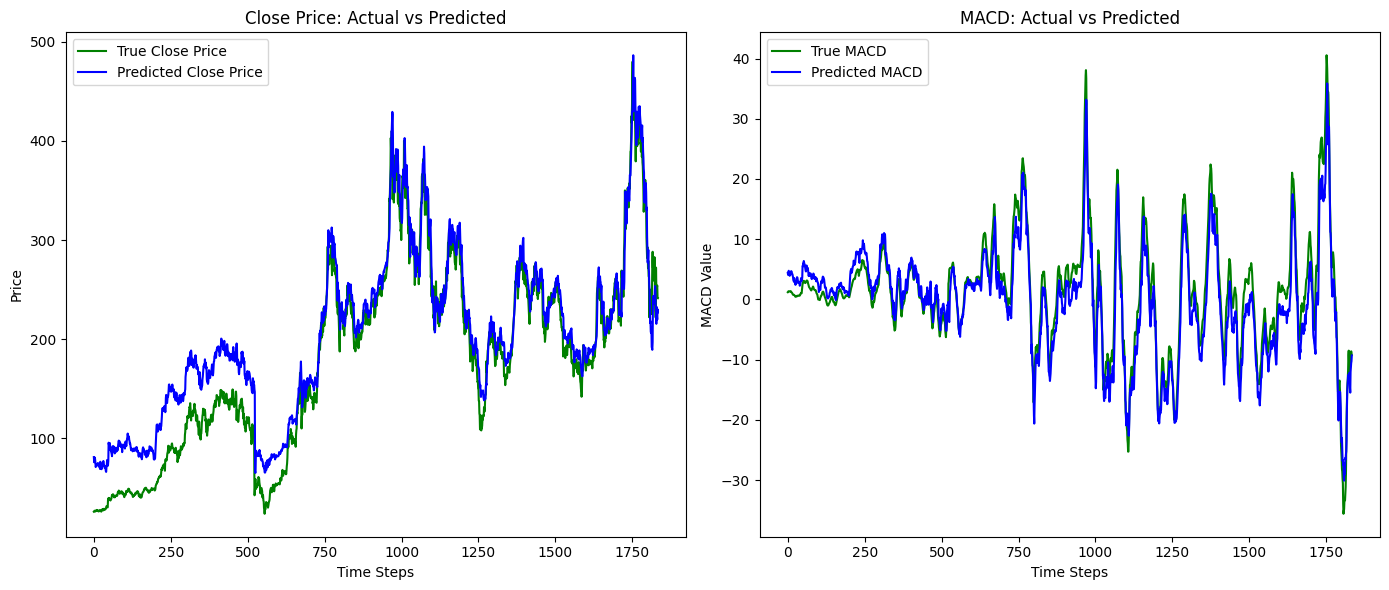

Close Price MSE: 959.3936541384546
Close Price R²: 0.8968548698031381
MACD MSE: 10.696269282392699
MACD R²: 0.8832475160424175


In [21]:
historical_encoded['target_close'] = historical_encoded['Close'].shift(-1)
historical_encoded['target_macd'] = historical_encoded['MACD'].shift(-1)
# identify all of the features and our targets list
features = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Previous_Close', 'Volume', 'SMA_20', 'EMA_20', 'RSI_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower', 'MACD', 'MACD_Signal', 'OBV', 'ATR_14', 'Close_Normalized', 'VWAP', 'year', 'month', 'weekday', 'day', 'Ticker_AAPL', 'Ticker_AMZN', 'Ticker_GOOGL', 'Ticker_META', 'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_TSLA']

targets = ['target_close', 'target_macd']

from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()
scaled_real_features = feature_scaler.fit_transform(historical_encoded[features])
scaled_real_targets = target_scaler.fit_transform(historical_encoded[targets])

def create_sequences(features, targets, sequence_length=10):
    X, y = [], []
    for i in range(len(features) - sequence_length):
        X.append(features[i:i+sequence_length])
        y.append(targets[i+sequence_length])
    return np.array(X), np.array(y)
X, y = create_sequences(scaled_real_features, scaled_real_targets, sequence_length=10)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False),
    Dense(32, activation='relu'),
    Dense(y_train.shape[1])  
])

model.compile(optimizer='adam', loss='mse')
model.summary()

history = model.fit(X_train, y_train, epochs=30, batch_size=16, validation_split=0.2)


import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# model prediction and inverse scaling
y_pred_scaled = model.predict(X_test)
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_test_orig = target_scaler.inverse_transform(y_test)

# extracting target variables
pred_close, pred_macd = y_pred[:, 0], y_pred[:, 1]
true_close, true_macd = y_test_orig[:, 0], y_test_orig[:, 1]

# converting to numpy and handle NaNs
pred_close = np.array(pred_close)
true_close = np.array(true_close)
pred_macd = np.array(pred_macd)
true_macd = np.array(true_macd)

# filtering out any rows where values are NaN (for clean metric evaluation)
valid_close = ~np.isnan(pred_close) & ~np.isnan(true_close)
valid_macd = ~np.isnan(pred_macd) & ~np.isnan(true_macd)

# apply filtering
true_close_clean = true_close[valid_close]
pred_close_clean = pred_close[valid_close]
true_macd_clean = true_macd[valid_macd]
pred_macd_clean = pred_macd[valid_macd]

# plots 
plt.figure(figsize=(14, 6))

# plot Close Price
plt.subplot(1, 2, 1)
plt.plot(true_close_clean, label='True Close Price', color='green')
plt.plot(pred_close_clean, label='Predicted Close Price', color='blue')
plt.title('Close Price: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('Price')
plt.legend()

# plot MACD
plt.subplot(1, 2, 2)
plt.plot(true_macd_clean, label='True MACD', color='green')
plt.plot(pred_macd_clean, label='Predicted MACD', color='blue')
plt.title('MACD: Actual vs Predicted')
plt.xlabel('Time Steps')
plt.ylabel('MACD Value')
plt.legend()

plt.tight_layout()
plt.show()

# evaluate metrics
print("Close Price MSE:", mean_squared_error(true_close_clean, pred_close_clean))
print("Close Price R²:", r2_score(true_close_clean, pred_close_clean))

print("MACD MSE:", mean_squared_error(true_macd_clean, pred_macd_clean))
print("MACD R²:", r2_score(true_macd_clean, pred_macd_clean))




After framing and normalizing the data, LSTM learns from the past 10 days of data and tracks sequential patterns across time steps. The model is then trained to minimize Mean Squared Error (MSE) between predicted and true values for both targets. Then the trained LSTM can predict on future sequences. 

**Graph 1: Close Price: Actual vs Predicted**: The true closed prices and predicted close prices follow eachother closely, with a good alignment during upward/downward trends. Some deviation is visible in regions with high volatility (near price spikes or drops). 

MSE: This model produces averaged square errors on the higher side (700-1000), so the models predicted closing prices are off by a substaintial amount. 

R2: A value closer to 1.0 indicates better predictions, this model produces an R2 around 0.7-0.9 indicating a strong performance. 

**Graph 2: MACD: Actual vs Predicted**: The predicted MACD is more volatile and underestimates the peaks and troughts of the true MACD. It captures the general direction but lacks amlitude swings, which might affect strategies relying on precise MACD values.

MSE: This model generates a MACD ranging from 20-50 which is relaticely modest but still on the higher side. 

R2: This model calculates an R2 ranging from 0.4-0.8 which is too wide a variation to be reliable. 

## importing libomp if you are on macos for the XGBoosting (1/2nd half of real time ensemble model)

In [22]:
!brew install libomp

==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:40e7f5d7514a7e9757facdd39006f7a351d3d7986d3a228be13c8b1c3216727b
######################################################################### 100.0%
==> Pouring portable-ruby-3.4.3.arm64_big_sur.bottle.tar.gz
==> Auto-updated Homebrew!
Updated 2 taps (homebrew/core and homebrew/cask).
==> New Formulae
bkmr                newsraft            tdom                undercutf1
infat               policy-engine       tmex                unoserver
==> New Casks
cloudpouch                               font-noto-serif-dives-akuru
elemental                                font-wdxl-lubrifont-tc
font-bizter

You have 15 outdated formulae installed.

To reinstall 20.1.3, run:
  brew reinstall libomp


## Creating the code for xgboosting ,  80:20 train:test ratio

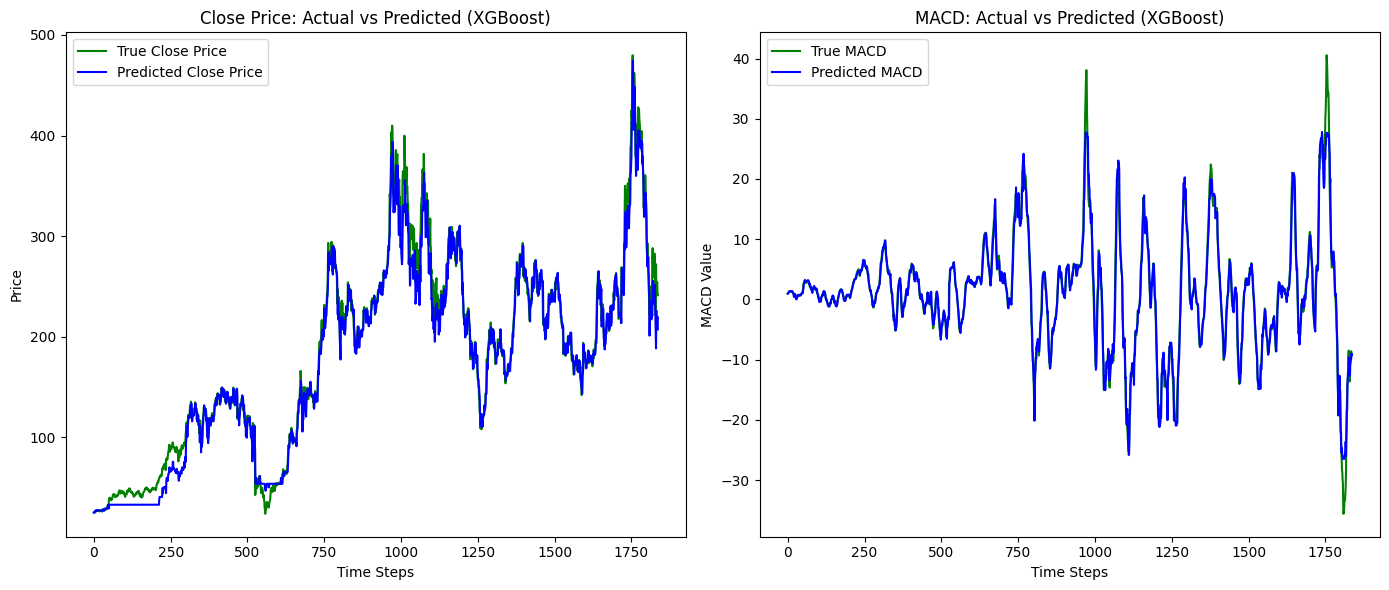

Close Price MSE: 200.11506271770438
Close Price R²: 0.9785432733073536
MACD MSE: 2.456038724849305
MACD R²: 0.973147881270877


In [23]:
def run_xgboost_prediction(historical_encoded):
    # define targets (next timestep prediction) 
    historical_encoded = historical_encoded.copy()
    historical_encoded['target_close'] = historical_encoded['Close'].shift(-1)
    historical_encoded['target_macd'] = historical_encoded['MACD'].shift(-1)
    historical_encoded.dropna(subset=['target_close', 'target_macd'], inplace=True)

    # feature selection 
    features = ['Open', 'High', 'Low', 'Close', 'Adj_Close', 'Previous_Close', 'Volume',
                'SMA_20', 'EMA_20', 'RSI_14', 'BB_Middle', 'BB_Std', 'BB_Upper', 'BB_Lower',
                'MACD', 'MACD_Signal', 'OBV', 'ATR_14', 'Close_Normalized', 'VWAP',
                'year', 'month', 'weekday', 'day',
                'Ticker_AAPL', 'Ticker_AMZN', 'Ticker_GOOGL', 'Ticker_META', 'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_TSLA']
    targets = ['target_close', 'target_macd']

    # scaling 
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    X = feature_scaler.fit_transform(historical_encoded[features])
    y = target_scaler.fit_transform(historical_encoded[targets])

    # Train-test split 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

    # XGBoost Regressor 
    xgb_model = XGBRegressor(
        n_estimators=80,
        max_depth=3,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.8,
        objective='reg:squarederror',
        random_state=42
    )
    xgb_model.fit(X_train, y_train)

    # Prediction & Evaluation 
    y_pred = xgb_model.predict(X_test)
    y_test_orig = target_scaler.inverse_transform(y_test)
    y_pred_orig = target_scaler.inverse_transform(y_pred)

    true_close, true_macd = y_test_orig[:, 0], y_test_orig[:, 1]
    pred_close, pred_macd = y_pred_orig[:, 0], y_pred_orig[:, 1]

    
    # visualization 
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(true_close, label='True Close Price', color='green')
    plt.plot(pred_close, label='Predicted Close Price', color='blue')
    plt.title('Close Price: Actual vs Predicted (XGBoost)')
    plt.xlabel('Time Steps')
    plt.ylabel('Price')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(true_macd, label='True MACD', color='green')
    plt.plot(pred_macd, label='Predicted MACD', color='blue')
    plt.title('MACD: Actual vs Predicted (XGBoost)')
    plt.xlabel('Time Steps')
    plt.ylabel('MACD Value')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    # metrics 
    print("Close Price MSE:", mean_squared_error(true_close, pred_close))
    print("Close Price R²:", r2_score(true_close, pred_close))
    print("MACD MSE:", mean_squared_error(true_macd, pred_macd))
    print("MACD R²:", r2_score(true_macd, pred_macd))


run_xgboost_prediction(historical_encoded)


XGBoost is a gradient boosting algorithm which excels in structured data, while LSTM is a type of recurrent neural network designed to capture temporal dependencies in sequential data. 

**Graph 1: Close Price: Actual vs Predicted**: The predicted close price aligns almost perfectly with the true closed price even in volatile regions. Compared to LSTM, there is less lag and bettwe alignment in sudden spikes or drops. 

MSE: XGBoost has a consistently lower error than LSTM, indicating tighter predictions. 

R2: XGBoost produces consistently higher R2 values, this means the model captures a higher variance in the close price 

**Graph 2: MACD: Actual vs Predicted**: The XGBoost performs significantly better than the LSTM model. It captures the directions, magnitude, and turning points more precisely. 

MSE: XGBoost consistently outperforms LSTM and produces significantly lower MACD MSE's. 

R2: This model regularly reports R2 values in the high 90s, which is greate for a technical indicator that is notoriously noisy and erratic. 